In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Rutas
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/tiff_separado/"
directorio_mascaras = "/content/drive/MyDrive/imagenes_balsas/Mascaras/tiff/"
nombres_imagenes = [f"Copia de Balsa{i}.tiff" for i in range(1, 26)]
mascaras = [f"Mask{i}.tiff" for i in range(1, 26)]

# Función para cargar imágenes y máscaras redimensionadas
def cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(256, 256)):
    imagenes = []
    etiquetas = []

    for nombre_imagen, nombre_mascara in zip(nombres_imagenes, mascaras):
        # Cargar y redimensionar las imágenes TIFF
        img = Image.open(os.path.join(directorio_imagenes, nombre_imagen)).resize(size)
        mask = Image.open(os.path.join(directorio_mascaras, nombre_mascara)).resize(size)

        # Convertir a arrays y normalizar
        imagenes.append(np.array(img) / 255.0)  # Normalizar imágenes
        etiquetas.append(np.array(mask) / 255.0)  # Normalizar máscaras (deben ser binarias)

    # Convertir listas a arrays de NumPy
    return np.array(imagenes), np.expand_dims(np.array(etiquetas), -1)

# Cargar datos redimensionados
imagenes, etiquetas = cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras)

# Dividir datos en entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes, etiquetas, test_size=0.2, random_state=42
)

# Data Augmentation
data_gen_args = dict(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                     shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Combinar generadores de imagen y máscara
train_image_generator = image_datagen.flow(imagenes_train, batch_size=4, seed=42)
train_mask_generator = mask_datagen.flow(etiquetas_train, batch_size=4, seed=42)

# Crear un Dataset desde los generadores
train_dataset = tf.data.Dataset.from_generator(
    lambda: zip(train_image_generator, train_mask_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Formato de las imágenes
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32)   # Formato de las máscaras
    )
)

# Prefetch para mejorar el rendimiento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Definir arquitectura U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Bloques de codificación
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bloque de cuello
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Bloques de decodificación
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(up1)
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(up2)
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(conv5)

    outputs = Conv2D(1, 1, activation="sigmoid")(conv5)

    return Model(inputs=[inputs], outputs=[outputs])

# Compilar modelo U-Net
modelo_unet = unet()

# Modificar la pérdida
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

modelo_unet.compile(optimizer=Adam(learning_rate=1e-4),
                    loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
                    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Entrenar modelo
history = modelo_unet.fit(
    train_dataset,
    epochs=50,
    validation_data=(imagenes_val, etiquetas_val),
    steps_per_epoch=len(imagenes_train) // 4,
    callbacks = callbacks
)

modelo_unet.save('/content/drive/MyDrive/imagenes_balsas/modelos/NUEVO_256modelo_unet.keras')


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 121s 23s/step - accuracy: 0.1810 - loss: 1.7021 - mean_io_u: 0.4996 - val_accuracy: 0.9900 - val_loss: 1.6445 - val_mean_io_u: 0.4984 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 22s/step - accuracy: 0.9800 - loss: 1.6228 - mean_io_u: 0.4993 - val_accuracy: 0.9923 - val_loss: 1.5058 - val_mean_io_u: 0.4984 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 110s 23s/step - accuracy: 0.9825 - loss: 1.4391 - mean_io_u: 0.4995 - val_accuracy: 0.9923 - val_loss: 1.1481 - val_mean_io_u: 0.4984 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 22s/step - accuracy: 0.9865 - loss: 1.0984 - mean_io_u: 0.4993 - val_accuracy: 0.9923 - val_loss: 1.0321 - val_mean_io_u: 0.4984 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 22s/step - accuracy: 0.9820 - loss: 1.0447 - mean_io_u: 0.4994 - val_accuracy: 0.9923 - val_loss: 1.0635 - val_mean_io_u: 0.4984 - learning_rate: 1.0000e-04
Epoch 6/50

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                     loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


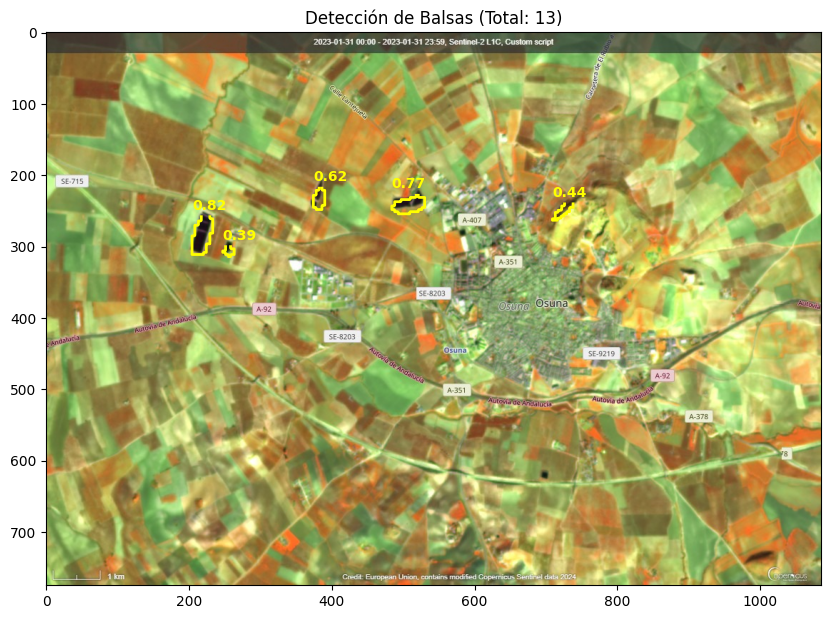

In [37]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

#modelo_unet_mejorado.save('/content/drive/MyDrive/imagenes_balsas/modelos/modelo_unet_mejorado.keras')
#modelo_unet_mejorado.save('/content/drive/MyDrive/imagenes_balsas/modelos/mi_modelo_unet.h5')




# Función para clasificar una nueva imagen
def clasificar_imagen_unet(imagen_path, modelo, size=(256, 256)):
    img = Image.open(imagen_path).resize(size)
    img_array = np.array(img) / 255.0
    prediccion = modelo.predict(np.expand_dims(img_array, axis=0))
    return prediccion[0, :, :, 0]



# Clasificación de imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/Balsa23.jpg"
clasificacion = clasificar_imagen_unet(imagen_prueba, modelo_unet)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)


estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Obtener dimensiones de la imagen original
imagen_original = Image.open(imagen_prueba)
ancho_original, alto_original = imagen_original.size

# Redimensionar la predicción a las dimensiones originales
clasificacion_redimensionada = cv2.resize(clasificacion_binaria, (ancho_original, alto_original), interpolation=cv2.INTER_NEAREST)

# Encontrar contornos en la predicción redimensionada
contornos, _ = cv2.findContours(clasificacion_redimensionada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")

# Mostrar la imagen original
plt.imshow(imagen_original)

# Dibujar contornos y bounding boxes en amarillo
for contorno in contornos:
    # Dibujar contorno
    #plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

     # Calcular la probabilidad promedio dentro del contorno
    mascara = np.zeros_like(clasificacion_redimensionada, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)

    # Redimensionar clasificacion para que coincida con la máscara
    clasificacion_resized = cv2.resize(clasificacion, (clasificacion_redimensionada.shape[1], clasificacion_redimensionada.shape[0]))

    probabilidad_promedio = np.mean(clasificacion_resized[mascara == 255])

     # Mostrar solo si la probabilidad es mayor a 0.2 (20%)
    if probabilidad_promedio > 0.3:
          # Dibujar contorno
          plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

          # Mostrar la probabilidad como texto
          x, y, w, h = cv2.boundingRect(contorno)
          plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='yellow', fontsize=10, fontweight='bold')





plt.show()






